In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import initializers, regularizers, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, ZeroPadding2D, MaxPooling2D, Input,DepthwiseConv2D, SeparableConv2D, BatchNormalization, AveragePooling2D, Activation
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications import ResNet50, xception, MobileNet, Xception, VGG16
from tensorflow.keras.applications.resnet50  import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings(action='ignore')

### # load dataset 

In [ ]:
import pickle5 as pickle
with open('E:/olive_young/CNN_mymodel/dataset/x_train.pickle',"rb") as fr:
    x_train = pickle.load(fr, encoding='bytes')
with open('E:/olive_young/CNN_mymodel/dataset/x_trn.pickle',"rb") as fr:
    x_trn = pickle.load(fr, encoding='bytes')
    
with open('E:/olive_young/CNN_mymodel/dataset/new_x_train.pickle',"rb") as fr:
    new_x_train = pickle.load(fr, encoding='bytes')
with open('E:/olive_young/CNN_mymodel/dataset/new_x_trn.pickle',"rb") as fr:
    new_x_trn = pickle.load(fr, encoding='bytes')
    
with open('E:/olive_young/CNN_mymodel/dataset/x_test.pickle',"rb") as fr:
    x_test = pickle.load(fr, encoding='bytes')
with open('E:/olive_young/CNN_mymodel/dataset/x_ts.pickle',"rb") as fr:
    x_ts  = pickle.load(fr, encoding='bytes')

with open('E:/olive_young/CNN_mymodel/dataset/x_val.pickle',"rb") as fr:
    x_val  = pickle.load(fr, encoding='bytes')
with open('E:/olive_young/CNN_mymodel/dataset/x_v.pickle',"rb") as fr:
    x_v = pickle.load(fr, encoding='bytes')
    
with open('E:/olive_young/CNN_mymodel/dataset/y_train.pickle',"rb") as fr:
    y_train  = pickle.load(fr, encoding='bytes')
with open('E:/olive_young/CNN_mymodel/dataset/new_y_train.pickle',"rb") as fr:
    new_y_train  = pickle.load(fr, encoding='bytes')
    
with open('E:/olive_young/CNN_mymodel/dataset/y_test.pickle',"rb") as fr:
    y_test  = pickle.load(fr, encoding='bytes')
with open('E:/olive_young/CNN_mymodel/dataset/y_val.pickle',"rb") as fr:
    y_val  = pickle.load(fr, encoding='bytes')

In [ ]:
print(x_train.shape, x_trn.shape)
print(new_x_train.shape, new_x_trn.shape)
print(x_test.shape, x_ts.shape)
print(x_val.shape, x_v.shape)

print(y_train.shape, new_y_train.shape)
print(y_test.shape, y_val.shape)

In [8]:
new_y_train = new_y_train.astype('int32')

In [3]:
# x_train =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/x_train.pickle')
# x_trn =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/x_trn.pickle')

# new_x_train =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/new_x_train.pickle')
# new_x_trn =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/new_x_trn.pickle')

# x_test =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/x_test.pickle')
# x_ts =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/x_ts.pickle')

# x_val =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/x_val.pickle')
# x_v =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/x_v.pickle')

# y_train = pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/y_train.pickle')
# new_y_train =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/new_y_train.pickle')

# y_test =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/y_test.pickle')

# y_val =  pd.read_pickle('E:/olive_young/CNN_mymodel/dataset/y_val.pickle')

# # modeling

* 모델링 목표 
 * 효율성 증대 및 자원의 절약
 * 전이 학습으로 돌려 본 4개의 모델들보다 가볍고 빠르면서도 성능이 좋은 모델 쌓기

In [83]:
def build_my_model(input_shape, output_node):

    def depthwise_bn_relu(x, s, padd):
        x = DepthwiseConv2D((3, 3), strides=(s, s), padding=padd, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    def pointwise_bn_relu(x, number_of_filter):
        x = Conv2D(number_of_filter, (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    input_tensor = Input(shape=input_shape, dtype='float32', name='input')

    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(input_tensor)
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = depthwise_bn_relu(x, 1, 'same')
    x = pointwise_bn_relu(x, 64)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)

    x = depthwise_bn_relu(x, 1, 'same')
    x = pointwise_bn_relu(x, 128)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)

    x = depthwise_bn_relu(x, 2, 'valid')
    x = pointwise_bn_relu(x, 512)

    x = depthwise_bn_relu(x, 1, 'same')
    x = pointwise_bn_relu(x, (256))
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)

    x = depthwise_bn_relu(x, 2, 'valid')
    x = pointwise_bn_relu(x, 1024)

    x = depthwise_bn_relu(x, 2, 'same')
    x = pointwise_bn_relu(x, 1024)

    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, 1024))(x)
    x = Dropout(0.001)(x)
    x = Conv2D(output_node, (1, 1), strides=(1, 1), padding='same')(x)
    x = Activation('softmax')(x)

    output_tensor = Reshape((output_node,))(x)

    my_model = Model(input_tensor, output_tensor)
    
    return my_model

In [84]:
def model_compile(model, learning_rate):
    optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    #optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999,)
    model.compile(optimizer=optimizer,
                  loss=['sparse_categorical_crossentropy'], metrics=['accuracy'])
    return model

In [85]:
input_shape = (x_trn.shape[1], x_trn.shape[2], 3)

model1 = build_my_model(input_shape, 30)
model1 = model_compile(model1, 0.01)
model1.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 75, 3)]      0         
_________________________________________________________________
zero_padding2d_26 (ZeroPaddi (None, 101, 76, 3)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 51, 38, 32)        864       
_________________________________________________________________
batch_normalization_76 (Batc (None, 51, 38, 32)        128       
_________________________________________________________________
activation_82 (Activation)   (None, 51, 38, 32)        0         
_________________________________________________________________
depthwise_conv2d_35 (Depthwi (None, 51, 38, 32)        288       
_________________________________________________________________
batch_normalization_77 (Batc (None, 51, 38, 32)        128 

In [86]:
plot_model(model1)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### # without augmentation

In [87]:
model_path_1 = 'E:/olive_young/CNN_mymodel/models/best_model_1.h5'

In [88]:
tf.random.set_seed(34)

cb_checkpoint = ModelCheckpoint(filepath=model_path_1 , monitor='val_accuracy',
                                verbose=1, save_best_only=True)

history1 = model1.fit(x_trn, y_train, validation_data=(x_v, y_val), shuffle=True,
                     epochs=100, batch_size=32, callbacks=[cb_checkpoint])

Epoch 1/100
338/338 [==============================] - 30s 84ms/step - loss: 1.8560 - accuracy: 0.4841 - val_loss: 3.9981 - val_accuracy: 0.0508

Epoch 00001: val_accuracy improved from -inf to 0.05083, saving model to E:/olive_young/CNN_mymodel/models\best_model_1.h5
Epoch 2/100
338/338 [==============================] - 26s 78ms/step - loss: 0.7543 - accuracy: 0.7874 - val_loss: 1.4980 - val_accuracy: 0.5922

Epoch 00002: val_accuracy improved from 0.05083 to 0.59222, saving model to E:/olive_young/CNN_mymodel/models\best_model_1.h5
Epoch 3/100
338/338 [==============================] - 26s 78ms/step - loss: 0.4544 - accuracy: 0.8744 - val_loss: 2.5521 - val_accuracy: 0.5492

Epoch 00003: val_accuracy did not improve from 0.59222
Epoch 4/100
338/338 [==============================] - 27s 79ms/step - loss: 0.3055 - accuracy: 0.9153 - val_loss: 3.5278 - val_accuracy: 0.3772

Epoch 00004: val_accuracy did not improve from 0.59222
Epoch 5/100
338/338 [==============================] - 27


Epoch 00035: val_accuracy did not improve from 0.96528
Epoch 36/100
338/338 [==============================] - 27s 79ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.1436 - val_accuracy: 0.9619

Epoch 00036: val_accuracy did not improve from 0.96528
Epoch 37/100
338/338 [==============================] - 27s 79ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.1449 - val_accuracy: 0.9622

Epoch 00037: val_accuracy did not improve from 0.96528
Epoch 38/100
338/338 [==============================] - 27s 79ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.1479 - val_accuracy: 0.9619

Epoch 00038: val_accuracy did not improve from 0.96528
Epoch 39/100
338/338 [==============================] - 27s 79ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.1439 - val_accuracy: 0.9606

Epoch 00039: val_accuracy did not improve from 0.96528
Epoch 40/100
338/338 [==============================] - 27s 79ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.1429 - val_accurac

338/338 [==============================] - 27s 79ms/step - loss: 6.2085e-04 - accuracy: 0.9998 - val_loss: 0.1430 - val_accuracy: 0.9667

Epoch 00075: val_accuracy improved from 0.96639 to 0.96667, saving model to E:/olive_young/CNN_mymodel/models\best_model_1.h5
Epoch 76/100
338/338 [==============================] - 27s 80ms/step - loss: 5.0613e-04 - accuracy: 0.9999 - val_loss: 0.1421 - val_accuracy: 0.9667

Epoch 00076: val_accuracy did not improve from 0.96667
Epoch 77/100
338/338 [==============================] - 27s 79ms/step - loss: 6.7228e-04 - accuracy: 0.9998 - val_loss: 0.1421 - val_accuracy: 0.9669

Epoch 00077: val_accuracy improved from 0.96667 to 0.96694, saving model to E:/olive_young/CNN_mymodel/models\best_model_1.h5
Epoch 78/100
338/338 [==============================] - 27s 79ms/step - loss: 6.9091e-04 - accuracy: 0.9999 - val_loss: 0.1434 - val_accuracy: 0.9650

Epoch 00078: val_accuracy did not improve from 0.96694
Epoch 79/100
338/338 [=========================

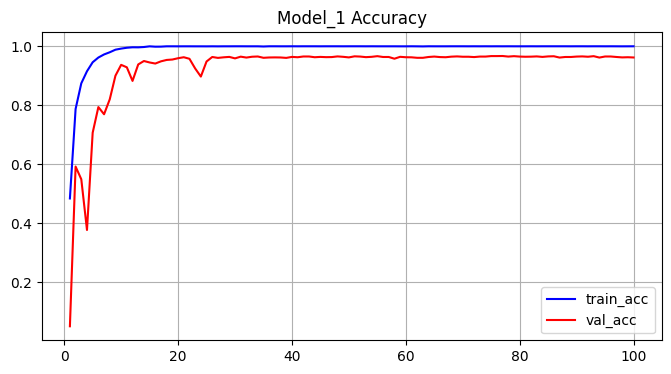

In [89]:
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']

epochs = range(1, len(acc1)+1)
plt.figure(figsize=(8, 4))
plt.title('Model_1 Accuracy')
plt.plot(epochs, acc1, 'b', label='train_acc')
plt.plot(epochs, val_acc1, 'r', label='val_acc')
plt.grid()
plt.legend()
plt.savefig('E:/olive_young/CNN_mymodel/metric/model_1_Accuracy.png')
plt.show()

In [90]:
best_model_1= load_model(model_path_1)
best_model_1.evaluate(x_ts, y_test)

113/113 [==============================] - 3s 19ms/step - loss: 0.1021 - accuracy: 0.9753


[0.10214661806821823, 0.9752777814865112]

In [91]:
# test image 3600장 예측 시간
import time
start_time = time.time()
pred_1 = best_model_1.predict(x_ts)
print("time : {}".format(time.time()-start_time))
print("pred_1 shape:", pred_1.shape)

time : 2.538283348083496
pred_1 shape: (3600, 30)


In [92]:
# test image 1장 예측 시간
temp = x_ts[1].reshape(1, 100, 75, 3)
start_time = time.time()
p = best_model_1.predict(temp)
print("time : {}".format(time.time()-start_time))

time : 0.034311532974243164


---

### # with augmentation

In [93]:
input_shape = (x_trn.shape[1], x_trn.shape[2], 3)

model2 = build_my_model(input_shape, 30)
model2 = model_compile(model1, 0.01)
model2.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 75, 3)]      0         
_________________________________________________________________
zero_padding2d_26 (ZeroPaddi (None, 101, 76, 3)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 51, 38, 32)        864       
_________________________________________________________________
batch_normalization_76 (Batc (None, 51, 38, 32)        128       
_________________________________________________________________
activation_82 (Activation)   (None, 51, 38, 32)        0         
_________________________________________________________________
depthwise_conv2d_35 (Depthwi (None, 51, 38, 32)        288       
_________________________________________________________________
batch_normalization_77 (Batc (None, 51, 38, 32)        128 

In [67]:
plot_model(model2, show_shapes=True, show_dtype=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [23]:
model_path_2 = 'E:/olive_young/CNN_mymodel/models/best_model_2.h5'

In [37]:
tf.random.set_seed(34)

cb_checkpoint = ModelCheckpoint(filepath=model_path_2 , monitor='val_accuracy',
                                verbose=1, save_best_only=True)

history2 = model2.fit(new_x_trn, new_y_train, validation_data=(x_v, y_val),
                     epochs=100, batch_size=32, callbacks=[cb_checkpoint])

Epoch 1/100
900/900 [==============================] - 70s 76ms/step - loss: 1.7648 - accuracy: 0.4931 - val_loss: 1.8729 - val_accuracy: 0.5344

Epoch 00001: val_accuracy improved from -inf to 0.53444, saving model to E:/olive_young/CNN_mymodel\best_model_2.h5
Epoch 2/100
900/900 [==============================] - 68s 75ms/step - loss: 0.7243 - accuracy: 0.7919 - val_loss: 0.8227 - val_accuracy: 0.7836

Epoch 00002: val_accuracy improved from 0.53444 to 0.78361, saving model to E:/olive_young/CNN_mymodel\best_model_2.h5
Epoch 3/100
900/900 [==============================] - 68s 75ms/step - loss: 0.3950 - accuracy: 0.8863 - val_loss: 0.6276 - val_accuracy: 0.8272

Epoch 00003: val_accuracy improved from 0.78361 to 0.82722, saving model to E:/olive_young/CNN_mymodel\best_model_2.h5
Epoch 4/100
900/900 [==============================] - 68s 75ms/step - loss: 0.2394 - accuracy: 0.9323 - val_loss: 0.3554 - val_accuracy: 0.8978

Epoch 00004: val_accuracy improved from 0.82722 to 0.89778, sa

900/900 [==============================] - 68s 75ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.0883 - val_accuracy: 0.9756

Epoch 00037: val_accuracy did not improve from 0.97806
Epoch 38/100
900/900 [==============================] - 68s 75ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.0926 - val_accuracy: 0.9761

Epoch 00038: val_accuracy did not improve from 0.97806
Epoch 39/100
900/900 [==============================] - 68s 75ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.0911 - val_accuracy: 0.9750

Epoch 00039: val_accuracy did not improve from 0.97806
Epoch 40/100
900/900 [==============================] - 68s 75ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.0981 - val_accuracy: 0.9739

Epoch 00040: val_accuracy did not improve from 0.97806
Epoch 41/100
900/900 [==============================] - 68s 75ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.1003 - val_accuracy: 0.9733

Epoch 00041: val_accuracy did not improve from 0.97806
Epo

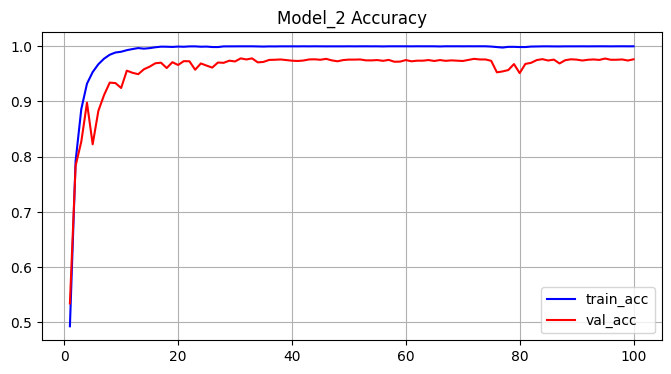

In [39]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

epochs = range(1, len(acc2)+1)
plt.figure(figsize=(8, 4))
plt.title('Model_2 Accuracy')
plt.plot(epochs, acc2, 'b', label='train_acc')
plt.plot(epochs, val_acc2, 'r', label='val_acc')
plt.grid()
plt.legend()
plt.savefig('E:/olive_young/CNN_mymodel/metric/model_2_Accuracy.png')
plt.show()

In [40]:
best_model_2= load_model(model_path_2)
best_model_2.evaluate(x_ts, y_test)

113/113 [==============================] - 2s 17ms/step - loss: 0.0886 - accuracy: 0.9789


[0.0886227935552597, 0.9788888692855835]

In [44]:
# test image 3600장 예측 시간
import time
start_time = time.time()
pred_2 = best_model_2.predict(x_ts)
print("time : {}".format(time.time()-start_time))
print("pred_1 shape:", pred_2.shape)

time : 2.1363437175750732
pred_1 shape: (3600, 30)


In [42]:
# test image 1장 예측 시간
temp = x_ts[1].reshape(1, 100, 75, 3)
start_time = time.time()
p = best_model_2.predict(temp)
print("time : {}".format(time.time()-start_time))

time : 0.2324225902557373


In [69]:
pred_class = np.argmax(best_model_2.predict(x_ts),axis=1)
pred_class

array([ 0,  0,  0, ..., 29, 29, 29], dtype=int64)

In [70]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_class)

In [71]:
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    if cmap is None:
        cmap = plt.get_cmap('Oranges')
    plt.figure(figsize=(18, 16))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    #normalize: If False, plot the raw numbers / If True, plot the proportions
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig('E:/olive_young/CNN_mymodel/metric/' + title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()

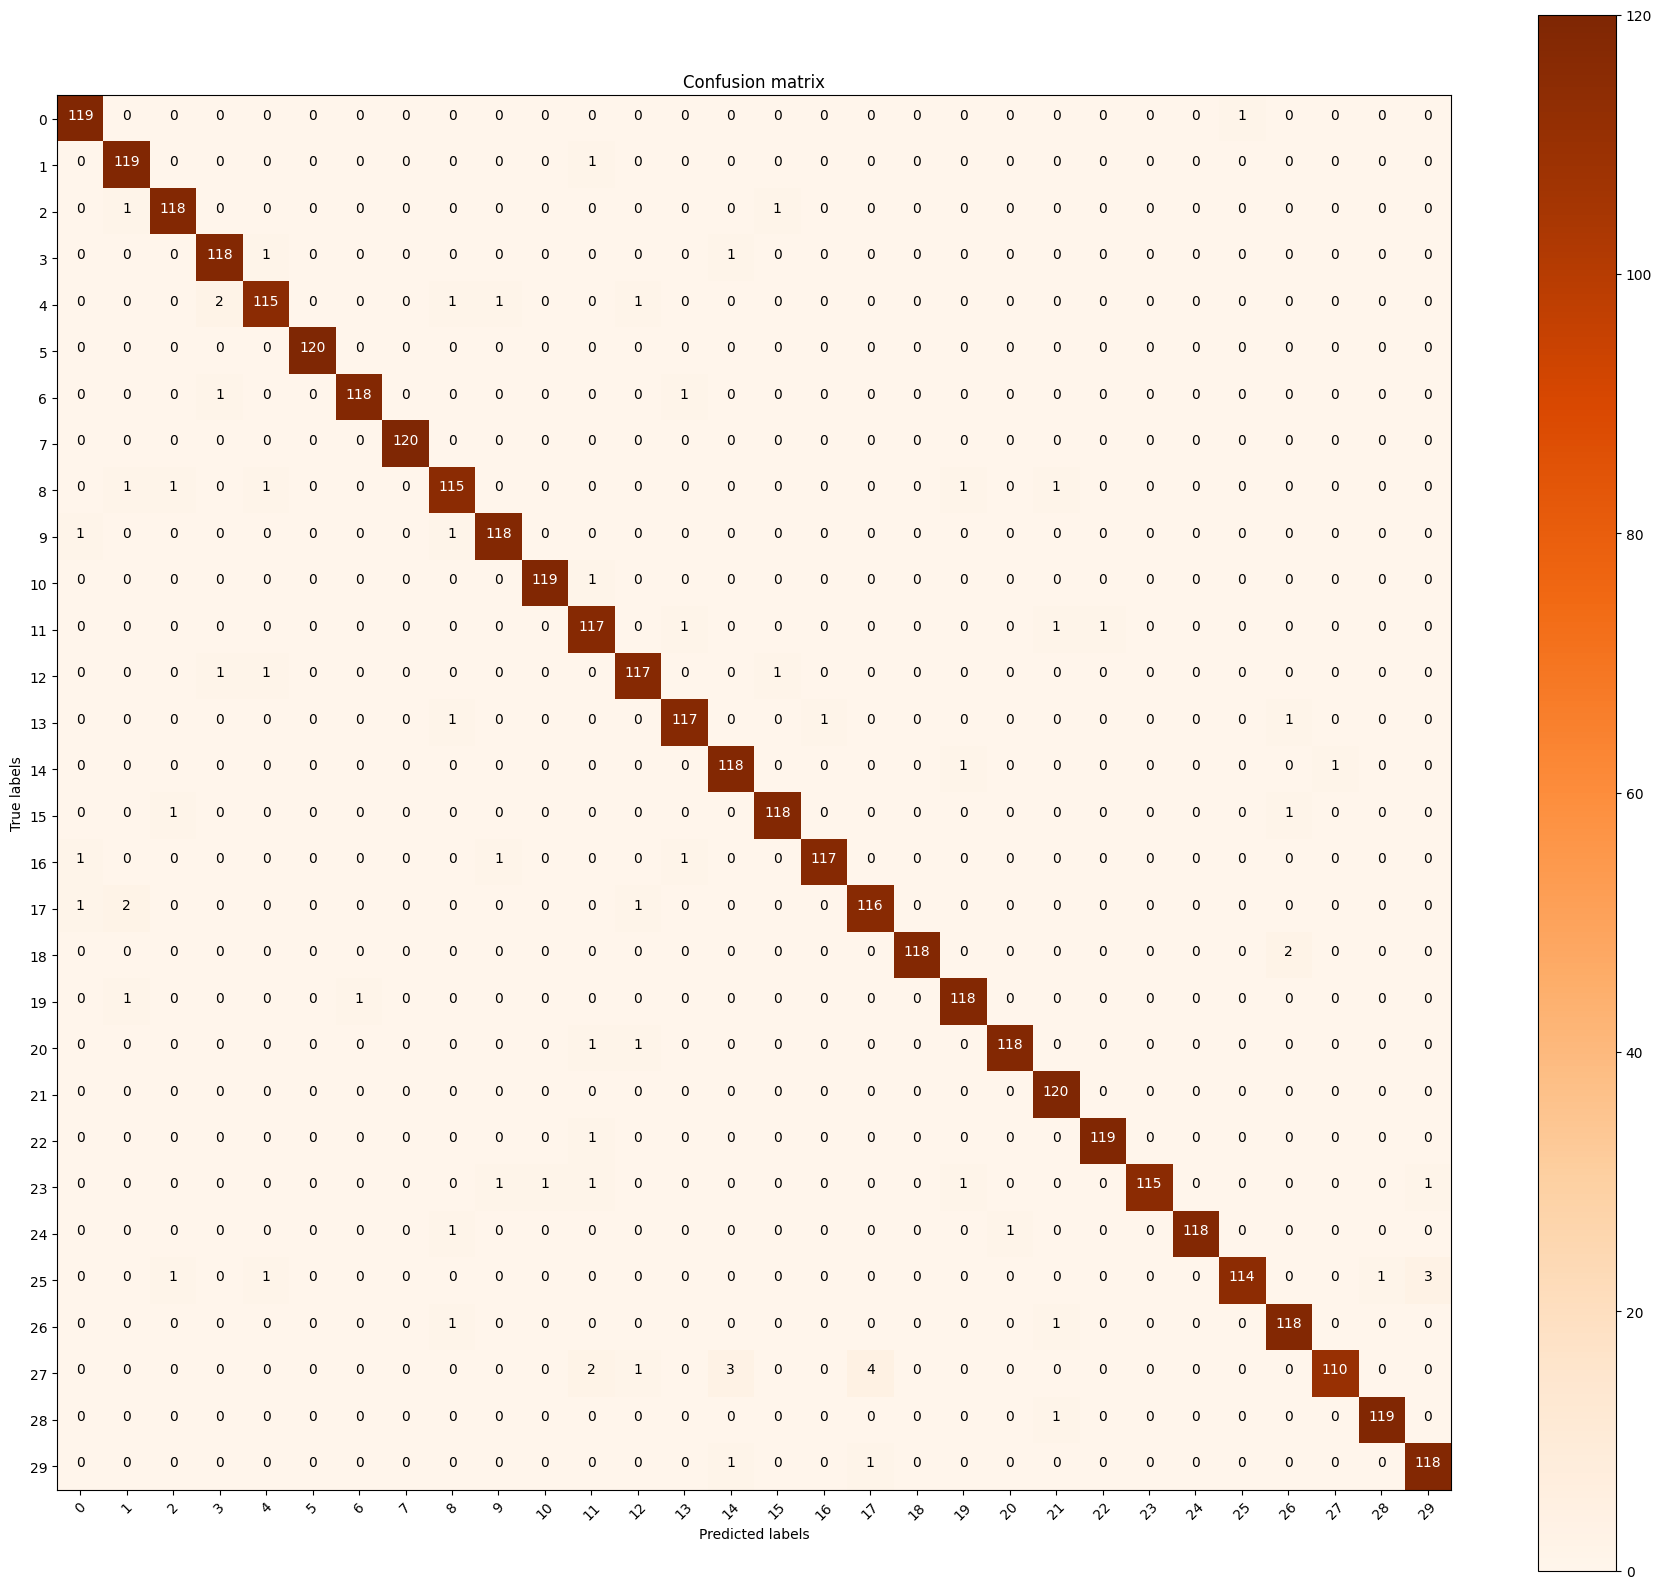

In [72]:
target_names = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,
                 22,23,24,25,26,27,28,29]
plot_confusion_matrix(cm, target_names)

In [73]:
def wrong_pred(pred, label, class_list):
    cnt = 0
    wrong_list=[]
    for i in range(pred.shape[0]):
        if class_list[i] != label[i]:
            wrong_list.append(i)
            cnt +=1
    return wrong_list

In [75]:
wrong_list2 = wrong_pred(pred_2, y_test, pred_class)
print(f'총 {pred_2.shape[0]}개 중 {len(wrong_list2)}개 틀림')

총 3600개 중 76개 틀림


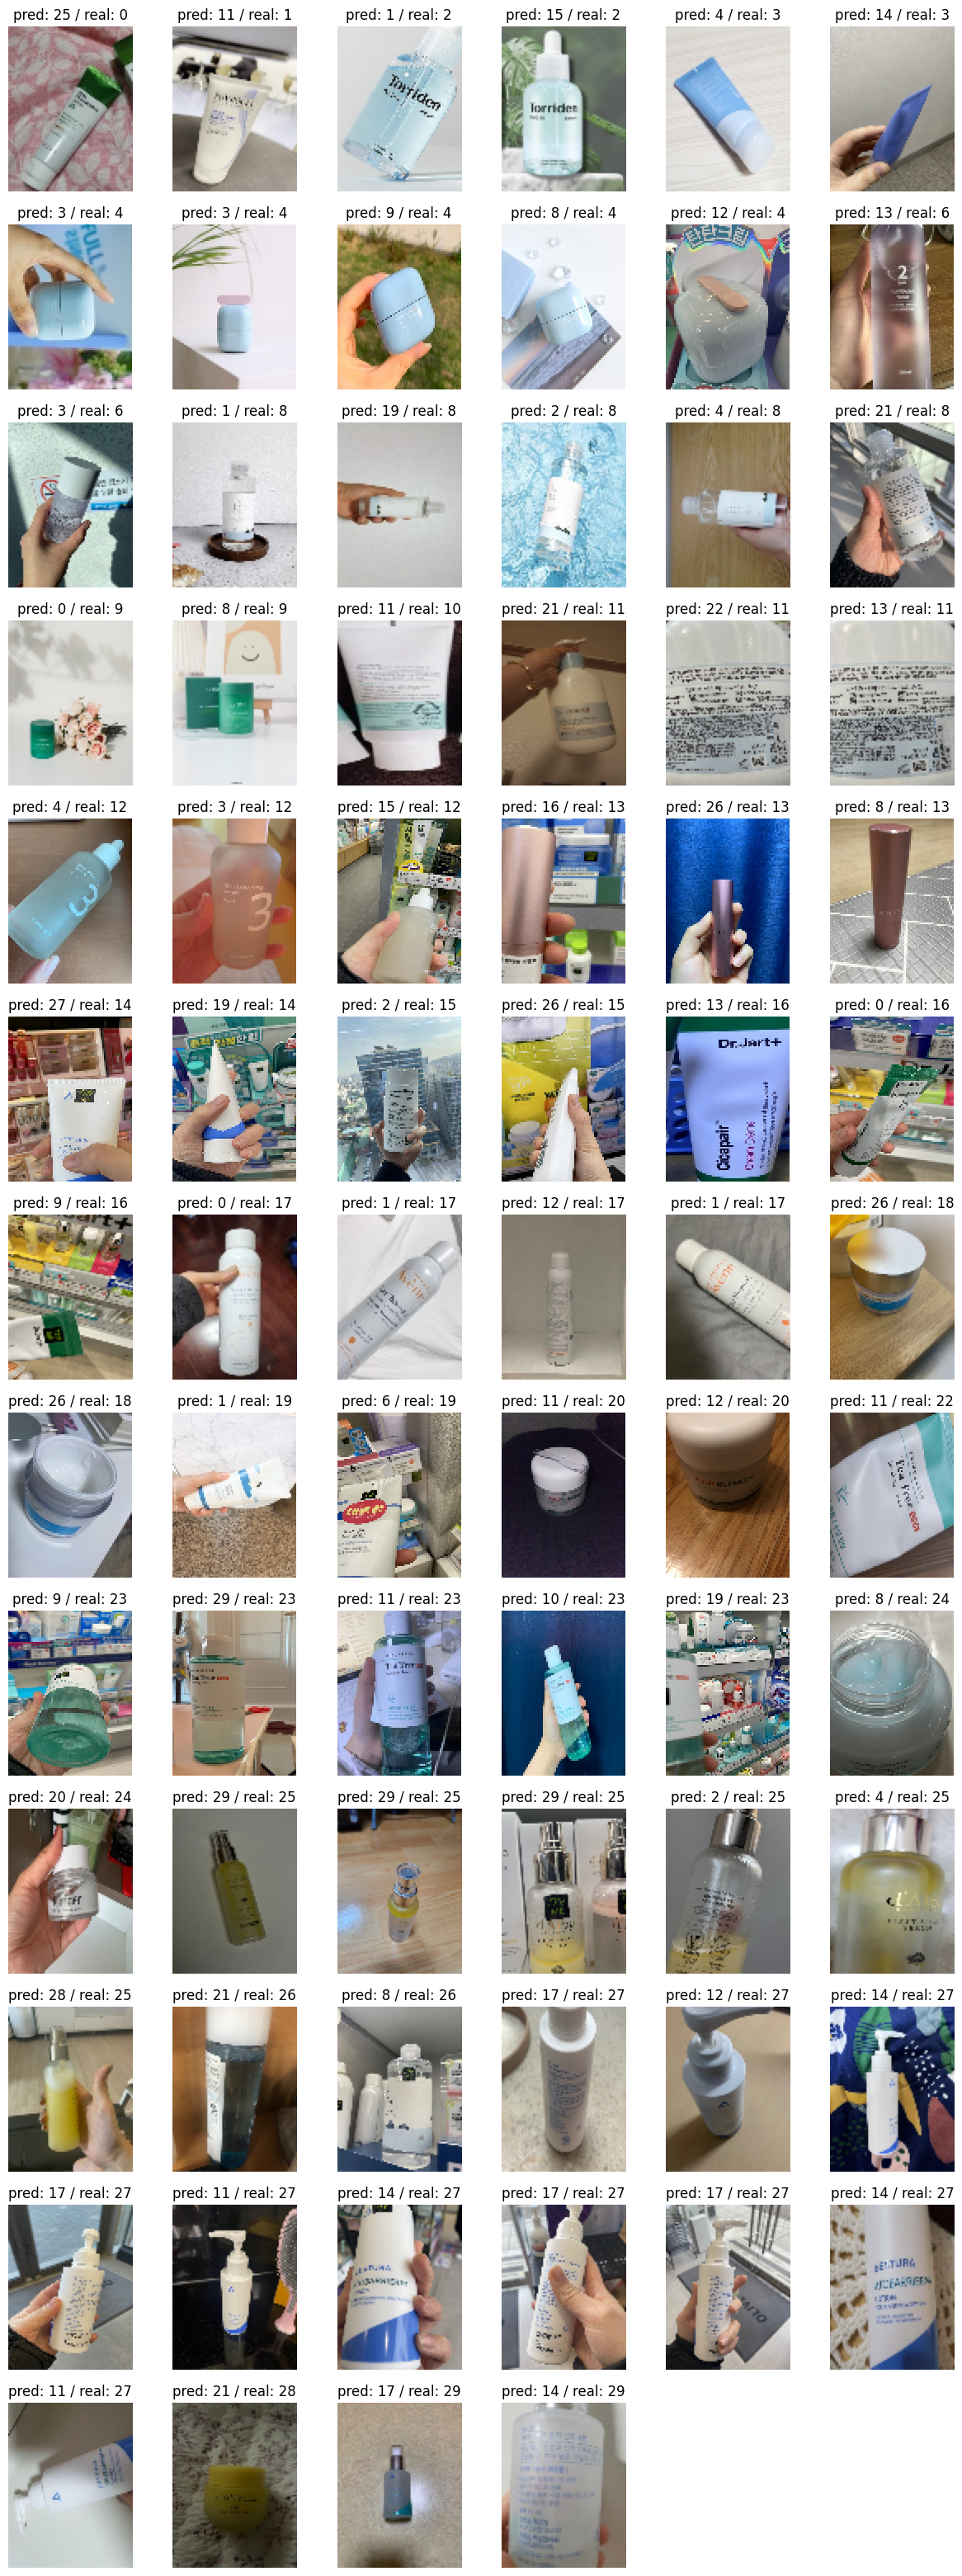

In [78]:
# 틀린 이미지 확인
fig = plt.figure(figsize=(15, 40))
rows = round((len(wrong_list2) / 6) +0.5)
for i in range(len(wrong_list2)):
     globals()[f'ax{i+1}'] = fig.add_subplot(rows, 6, i+1)
for i, val in enumerate(wrong_list2):
    img = x_test[val]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    globals()[f'ax{i+1}'].imshow(img)
    globals()[f'ax{i+1}'].set_title(f'pred: {pred_class[val]} / real: {y_test[val]}')
    globals()[f'ax{i+1}'].axis('off')
plt.show()

In [80]:
category_num= 30
wrong_category = []
for val in wrong_list2:
    wrong_category.append(y_test[val])
correct_rates = []
for i in range(category_num):
    total = list(y_test).count(i)
    wrong = wrong_category.count(i)
    correct_rate = round(100-(wrong/total*100), 2)
    correct_rates.append(correct_rate)
    print(f'{i} : {wrong}/{total}, 정답률: {correct_rate}%')

0 : 1/120, 정답률: 99.17%
1 : 1/120, 정답률: 99.17%
2 : 2/120, 정답률: 98.33%
3 : 2/120, 정답률: 98.33%
4 : 5/120, 정답률: 95.83%
5 : 0/120, 정답률: 100.0%
6 : 2/120, 정답률: 98.33%
7 : 0/120, 정답률: 100.0%
8 : 5/120, 정답률: 95.83%
9 : 2/120, 정답률: 98.33%
10 : 1/120, 정답률: 99.17%
11 : 3/120, 정답률: 97.5%
12 : 3/120, 정답률: 97.5%
13 : 3/120, 정답률: 97.5%
14 : 2/120, 정답률: 98.33%
15 : 2/120, 정답률: 98.33%
16 : 3/120, 정답률: 97.5%
17 : 4/120, 정답률: 96.67%
18 : 2/120, 정답률: 98.33%
19 : 2/120, 정답률: 98.33%
20 : 2/120, 정답률: 98.33%
21 : 0/120, 정답률: 100.0%
22 : 1/120, 정답률: 99.17%
23 : 5/120, 정답률: 95.83%
24 : 2/120, 정답률: 98.33%
25 : 6/120, 정답률: 95.0%
26 : 2/120, 정답률: 98.33%
27 : 10/120, 정답률: 91.67%
28 : 1/120, 정답률: 99.17%
29 : 2/120, 정답률: 98.33%


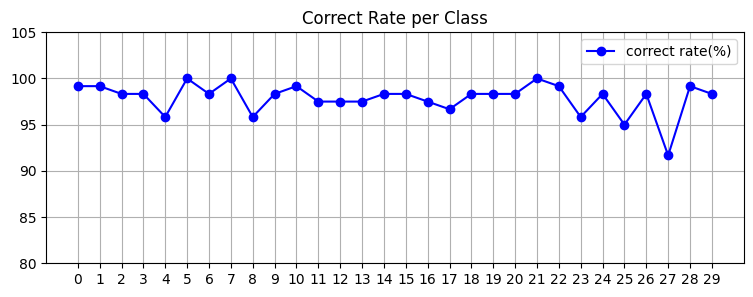

In [81]:
category = range(category_num)
plt.figure(figsize=(9, 3))
plt.title('Correct Rate per Class')
plt.plot(category, correct_rates, 'bo-', label='correct rate(%)')
plt.ylim(80, 105)
plt.xticks(range(category_num))
plt.legend()
plt.grid()
plt.show()

In [82]:
print(classification_report(test_labels, predi,target_names=target_names))

NameError: name 'classification_report' is not defined